# Intro to SMuRF
The SMuRF software consists of a server and client.  The server and client are started in docker containers.  The SMuRF server provides and EPICS channel access interface to access PVs (registers, and higher level controls) and acquires the streaming data.  It can perform filtering/downsampling for CMB applications.



## Server startup

In a separate terminal we'll start the server with:
```bash
cd /home/cryo/docker/smurf/dev_sw/slotN/v4.1.0
./run.sh -N 2; docker logs -f smurf_server_s2
```
-N 2 specifies slot 2 and EPICS server prefix smurf_server_s2

A GUI will pop up that we can use to interrogate the FPGA registers


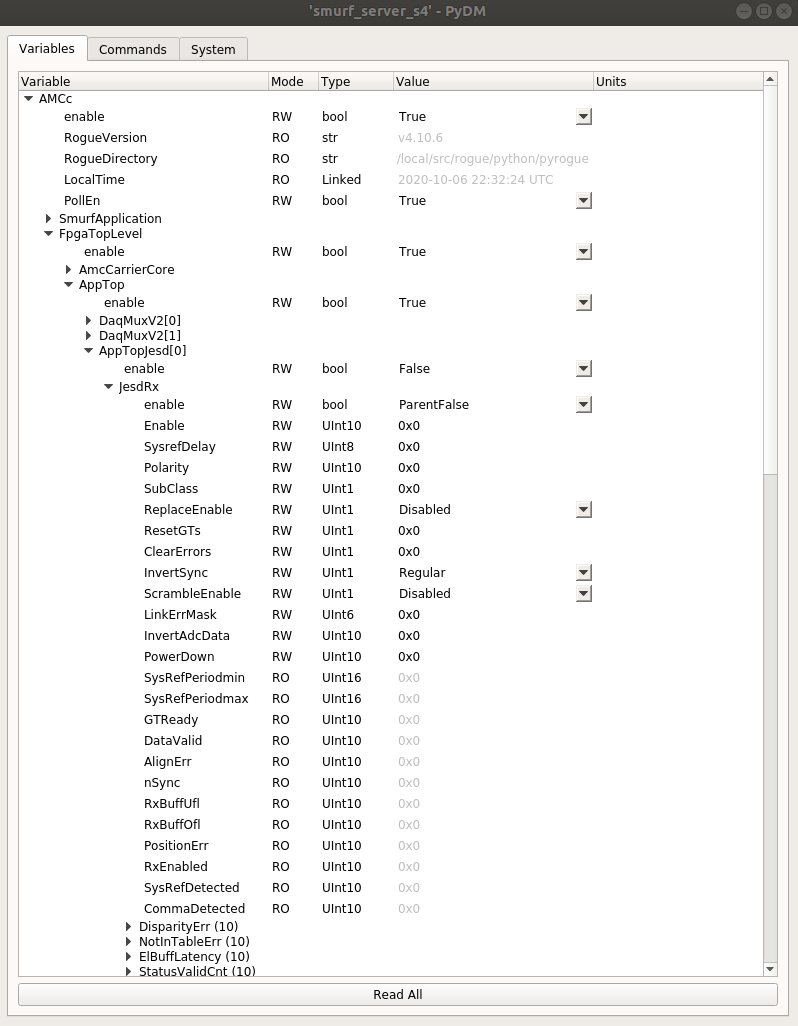

## PySMuRF Setup

PySMuRF is the client side control.  It communicates with the server via EPICS channel access (CA).  First we start the server and do imports

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [2]:
epics_prefix = "smurf_server_s2"
config_file  = "/usr/local/src/pysmurf/cfg_files/mit/experiment_mit.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=False)

Next we run a setup command.  This will initialize the FPGA and load the configuration defined in config_file.

In [3]:
S.setup()

[ 2021-12-14 20:14:48 ]  Setting up...
[ 2021-12-14 20:14:48 ]  Toggling DACs
[ 2021-12-14 20:14:48 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[0] 1
[ 2021-12-14 20:14:48 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[1] 1
[ 2021-12-14 20:14:48 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[0] 0
[ 2021-12-14 20:14:48 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[1] 0
[ 2021-12-14 20:14:48 ]  caput smurf_server_s2:AMCc:ReadAll 1
[ 2021-12-14 20:14:50 ]  Waiting 20.00 seconds after...
[ 2021-12-14 20:15:10 ]  Done waiting.
[ 2021-12-14 20:15:10 ]  caget smurf_server_s2:AMCc:SmurfApplication:SmurfVersion
[ 2021-12-14 20:15:10 ]  4.1.0+2.gc4f1e29c.dirty
[ 2021-12-14 20:15:10 ]  caput smurf_server_s2:AMCc:setDefaults 1
[ 2021-12-14 20:15:45 ]  caget smurf_server_s2:AMCc:SmurfApplication:ConfiguringInProgress
canno

[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:feedbackLimit 1536.0
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:feedbackPolarity 1
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppTopJesd[0]:JesdTx:dataOutMux[6] UserData
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppTopJesd[0]:JesdTx:dataOutMux[7] UserData
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:dspEnable 1
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentGain 0.0001
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentAverages 1
[ 2021-12-14 20:16:23 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentConvergeHz 500.

[ 2021-12-14 20:16:30 ]  {'hemt_Vg': 0.6099967296000001, 'hemt_Id': -0.941, '50K_Vg': -0.7399977408, '50K_Id': -0.4963}
[ 2021-12-14 20:16:30 ]  {'hemt_Vg': 0.6099967296000001, 'hemt_Id': -0.941, '50K_Vg': -0.7399977408, '50K_Id': -0.4963}
[ 2021-12-14 20:16:31 ]  Cryocard temperature = -8.928571428571429
[ 2021-12-14 20:16:31 ]  Configuring the system to take timing from ext_ref
[ 2021-12-14 20:16:31 ]  Select external reference for bay 0
[ 2021-12-14 20:16:36 ]  smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:SelExtRef sent
[ 2021-12-14 20:16:36 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:RtmCryoDet:RampStartMode 0
[ 2021-12-14 20:16:36 ]  Done with setup.


True

### Inspecting the SMuRF digitizers

SMuRF uses x8 RF ADCs and x8 RF DACs.  They are upmixed and combined in via x2 quadruplexers to form 4GHz analog bandwidth from 4-8GHz.  SMuRF uses a 750MHz intermediate frequency withand the RF ADCs and DACs perform down/up conversion to/from complex baseband.  






The digitizers are upmixed and combined with a multiplexer:

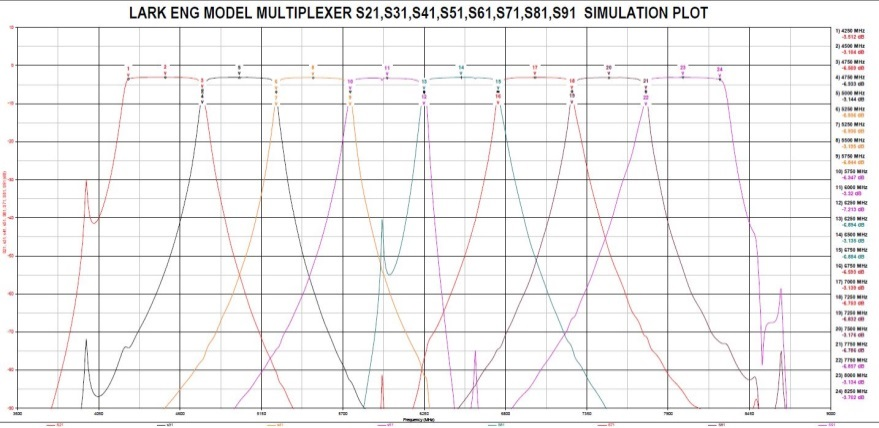

### Acquiring data from the digitzers

The SMuRF ADC and DACs are pictured below.  We can interrogate the raw ADC/DAC data with the following commands.  Here "band" defines which ADC/DAC to read data from.  Band 0...3 address AMC in the slot 0 and (when using low band AMC) correspond to 4-4.5GHz, 4.5-5GHz, 5-5.5GHz, and 5.5-6GHz.  Band 4...7 address the AMC in slot 1 and (when using the high band AMC) correspond to 6-6.5GHz, 6.5-7GHz, 7-7.5GHz and 7.5-8GHz.

The raw digitizer data is plotted in the top and a PSD is plotted below.  Raw data are 16-bit numbers +32767/-32768.  Let's look at the ADC data with no signals being played out of the DAC.



[ 2021-12-14 20:16:36 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2021-12-14 20:16:36 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:16:37 ]  ADC plot saved to /data/smurf_data/20211214/1639512888/plots/1639512996_adc2.png
[ 2021-12-14 20:16:37 ]  Saving raw adc data to /data/smurf_data/20211214/1639512888/outputs/1639512996_adc2


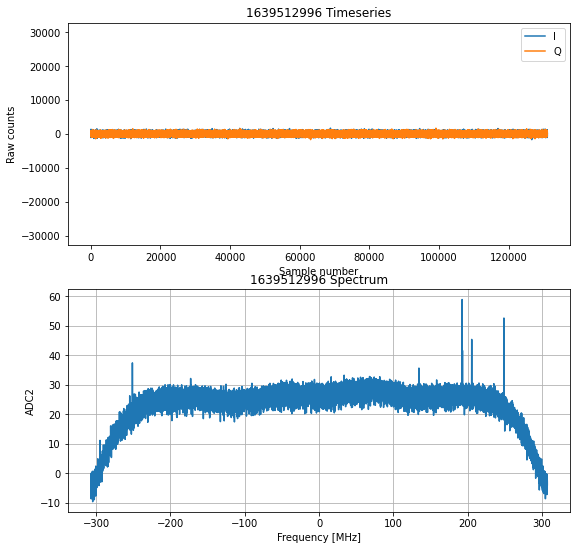

In [4]:
adc_data = S.read_adc_data(data_length=2**16, band=2, make_plot=True, show_plot=True)

[ 2021-12-14 20:16:38 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2021-12-14 20:16:38 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:16:39 ]  DAC plot saved to /data/smurf_data/20211214/1639512888/plots/1639512998_dac2.png
[ 2021-12-14 20:16:39 ]  Saving raw dac data to /data/smurf_data/20211214/1639512888/outputs/1639512998_dac2


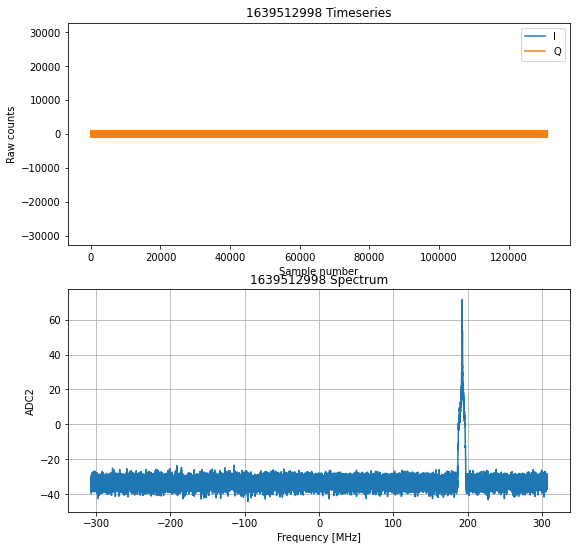

In [5]:
dac_data = S.read_dac_data(data_length=2**16, band=2, make_plot=True, show_plot=True)

Note the PSD frequency is plotted +/- 0MHz. Each digitizer has complex data at 614.4MHz corresponding to +/- 307.2MHz BW at baseband.  For band=3 this is 0MHz + 5750MHz = 4250MHz.


### Transfer function of the system

Next we can look at a transfer function estimate.  This will play a known random number sequence through the DAC and record the ADC response.  We'll use cross correlation to generate a transfer function estimate:

[ 2021-12-14 20:16:39 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-12-14 20:16:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:16:40 ]  ADC2 max count: 2315
[ 2021-12-14 20:16:40 ]  ADC2 min count: -2534
[ 2021-12-14 20:16:40 ]  ADC2 not saturated
[ 2021-12-14 20:16:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-12-14 20:16:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:16:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-12-14 20:16:41 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:16:41 ]  UC (DAC) att: 0
[ 2021-12-14 20:16:41 ]  DC (ADC) att: 0


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


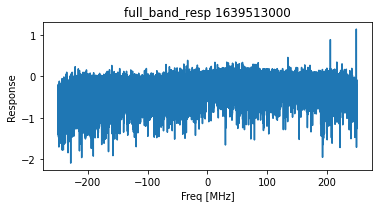

(array([-3.07200000e+08, -3.07197656e+08, -3.07195312e+08, ...,
         3.07192969e+08,  3.07195312e+08,  3.07197656e+08]),
 array([ 2.42505070e-03-0.00451035j,  4.34764948e-03+0.00151202j,
         1.14321919e-03+0.00172504j, ...,  3.02723066e-03+0.00317437j,
        -2.76364793e-03+0.00621701j, -8.24038796e-05-0.00163167j]))

In [6]:
S.full_band_resp(band=2, make_plot=True, show_plot=True)

Here we can see a resonator around 0MHz baseband or 4250MHz RF.  We also have a rotated resonator around -200MHz.  Note the resonator around 0MHz baseband is much deeper than the other.

### Identifying resonator locations

Each SMuRF band is processed by an oversampled x2 polyphase filter bank.  The filter bank breaks the +/-307.2MHz band into subbands.  Subband 0...127 correspond to -307.2MHz...307.2MHz.  Only subbands +/-250MHz are processed.  We can do a tone sweep to see the subband structure and identify resonator locations within each subband.  The plot shows the interleaved subbands in different colors.

[ 2021-12-14 20:16:56 ]  Sweeping across frequencies 5000.0MHz to 5500.0MHz
[ 2021-12-14 20:16:56 ]  Working on band 2
[ 2021-12-14 20:17:47 ]  serial find freq complete ; etaScanInProgress = 0


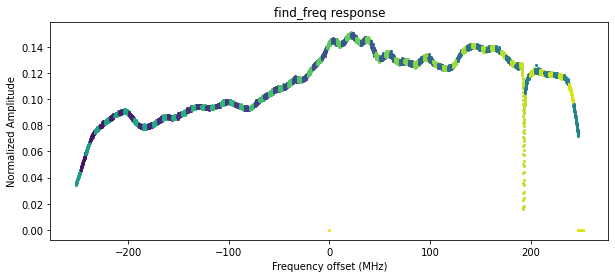

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [7]:
S.find_freq(band=2, tone_power=12, make_plot=True, show_plot=True)

### Fine resolution resonator scans
Next we run a fine resonator scan and set the nominal tone frequency, drive power and rotation.  Feedback operates on the RF demodulated Q and performs feedback to drive Q to 0.

In [8]:
S.setup_notches(band=2, tone_power=12, sweep_width=1, df_sweep=0.02, new_master_assignment=True)
# Plots will be saved in S.plot_dir
S.plot_tune_summary(band=2, eta_scan=True)
print("These plots are saved at: " + S.plot_dir)
# run a gradient descent to find resonator dip
S.run_serial_gradient_descent(0) 
# run eta scan to normalize resonator gain (delta Q -> delta frequency) and apply rotation such that Q is nominally 0
S.run_serial_eta_scan(0) 

[ 2021-12-14 20:17:50 ]  freq 5442.7600 - 1 of 2
[ 2021-12-14 20:17:50 ]  freq 5497.2000 - 2 of 2
[ 2021-12-14 20:17:50 ]  Writing new channel assignment to /data/smurf_data/tune/1639513070_channel_assignment_b2.txt
[ 2021-12-14 20:17:50 ]  Old master assignment file: /data/smurf_data/tune/1639512346_channel_assignment_b2.txt
[ 2021-12-14 20:17:50 ]  New master assignment file: /data/smurf_data/tune/1639513070_channel_assignment_b2.txt
[ 2021-12-14 20:17:51 ]  serial find freq complete ; etaScanInProgress = 0
[ 2021-12-14 20:17:51 ]  Assigning channels
[ 2021-12-14 20:17:51 ]  Writing new channel assignment to /data/smurf_data/tune/1639513071_channel_assignment_b2.txt
[ 2021-12-14 20:17:51 ]  Old master assignment file: /data/smurf_data/tune/1639513070_channel_assignment_b2.txt
[ 2021-12-14 20:17:51 ]  New master assignment file: /data/smurf_data/tune/1639513071_channel_assignment_b2.txt
[ 2021-12-14 20:17:51 ]  Saving to : /data/smurf_data/tune/1639513071_tune.npy
[ 2021-12-14 20:17:5

Here's our eta scan, the complex response is multiplied by the complex value eta to apply the scaling/rotation for feedback.

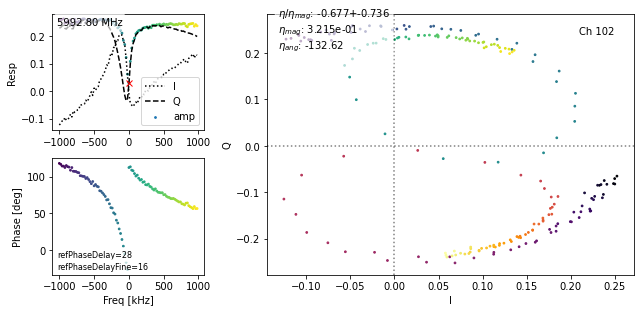

### Looking at on resonance noise
Now we can examine resonator noise.  The eta scan sets up with feedback enabled so we'll turn it off and look at open loop frequency error (quadrature voltage).

First we'll get of list of resonators that are on and tracking:

In [11]:
S.which_on(band=2)

array([10, 22])

[ 2021-12-14 20:20:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:readoutChannelSelect 10
[ 2021-12-14 20:20:58 ]  Writing to file : /data/smurf_data/20211214/1639512888/outputs/1639513259.dat
[ 2021-12-14 20:20:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-12-14 20:20:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:20:59 ]  Data acquisition in progress...
[ 2021-12-14 20:20:59 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-12-14 20:21:00 ]  Done taking data


Text(0, 0.5, 'Frequency error (MHz)')

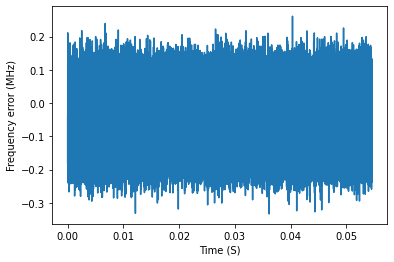

In [9]:
S.set_feedback_enable(band=2, val=0)
f, df, sync = S.take_debug_data(band=2, channel=10, nsamp=2**19, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/9.6e6
plt.plot(t, df)
plt.xlabel('Time (S)')
plt.ylabel('Frequency error (MHz)')

Text(0, 0.5, 'MHz/rt.Hz')

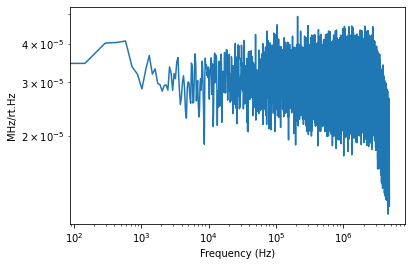

In [10]:
freq, pxx = signal.welch(df, nperseg=len(df)/8, fs=9.6e6)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')

### Flux ramp setup
Next we enable and configure the flux ramp.  For this example we'll setup 4phi0 flux ramp amplitude at 4kHz flux ramp rate (16kHz phi0 rate).

First we'll get a list of resonators that are on and tracking:

In [11]:
S.which_on(band=2)

array([10, 22])

Next we'll do tracking setup and view results for one of the enabled channels.  We'll set:  

reset_rate = 4 (kHz)  
n_phi0     = 4 (requested)  

meas_flux_ramp_amp = True (measure and adjust flux ramp amplitude to achieve requested phi0)
lms_freq_hz = None (we'll use requested reset rate, n_phi0, and meas_flux_ramp_amp for this)

Track the middle 3 phi0:  

start_feedback = 0.125  
end_feedback   = 0.875  

lms_enable1 = 1 (track fundamental phi0 response)  
lms_enable2 = 0 (don't track 2nd harmoncis of phi0 response)  
lms_enable3 = 0 (don't track 3rd harmonic of phi0 response)  

[ 2021-12-14 20:32:34 ]  Starting fraction full scale : 0.650
[ 2021-12-14 20:32:34 ]  Percent full scale = 64.991%
[ 2021-12-14 20:32:34 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadout 0
[ 2021-12-14 20:32:34 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadoutOpt2 0
[ 2021-12-14 20:32:34 ]  Writing to file : /data/smurf_data/20211214/1639512888/outputs/1639513954.dat
[ 2021-12-14 20:32:34 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-12-14 20:32:34 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:32:34 ]  Data acquisition in progress...
[ 2021-12-14 20:32:34 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-12-14 20:32:35 ]  Done taking data
[ 2021-12-14 20:32:35 ]  f and df are different sizes. Choosing the smaller value. Not sure why this is happening.
[ 2021-12-14 20:32:

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00023289],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00023518],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00023746],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00077534],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00077763],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00077991]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00023289],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00023518],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00023746],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00077534],
        [0. 

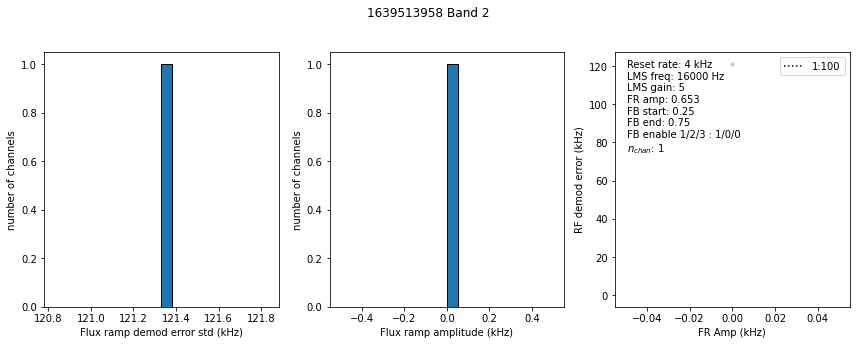

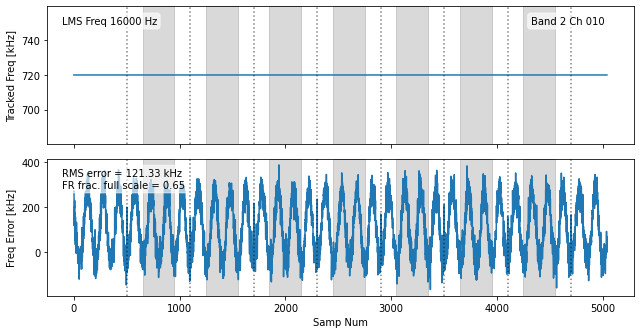

In [17]:
S.tracking_setup(band=2, channel=10, reset_rate_khz=4, n_phi0=4, lms_freq_hz=None, meas_flux_ramp_amp=True, make_plot=True, lms_gain=5, feedback_start_frac=0.25, feedback_end_frac=1-0.25, lms_enable1=1, lms_enable2=0, lms_enable3=0) 

The plots are an overall tuning summary (tracked frequency throw, RMS tracking error) and a channel plot for the requested channel.  Here we see tracked frequency is aroudn -80kHz to -40kHz for 4 phi0.  The dottled lines indicate flux ramp reset and the grey area shows what part of the response we are tracking.  The bottom plot shows frequency errror.  Here we are only tracking the 16kHz and the error shows this.

Next let's try tracking 3 harmonics of the phi0 rate.

[ 2021-12-14 20:34:26 ]  Starting fraction full scale : 0.653
[ 2021-12-14 20:34:26 ]  Percent full scale = 65.253%
[ 2021-12-14 20:34:26 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadout 0
[ 2021-12-14 20:34:26 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadoutOpt2 0
[ 2021-12-14 20:34:26 ]  Writing to file : /data/smurf_data/20211214/1639512888/outputs/1639514067.dat
[ 2021-12-14 20:34:26 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-12-14 20:34:26 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:34:26 ]  Data acquisition in progress...
[ 2021-12-14 20:34:26 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-12-14 20:34:28 ]  Done taking data
[ 2021-12-14 20:34:28 ]  Number of channels on : 2
[ 2021-12-14 20:34:28 ]  Number of channels on with flux ramp response : 1
[ 2021-1

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00097618],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00097847],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00098076],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00014534],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00014763],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00014992]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00097733],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00097961],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.0009819 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00014648],
        [0. 

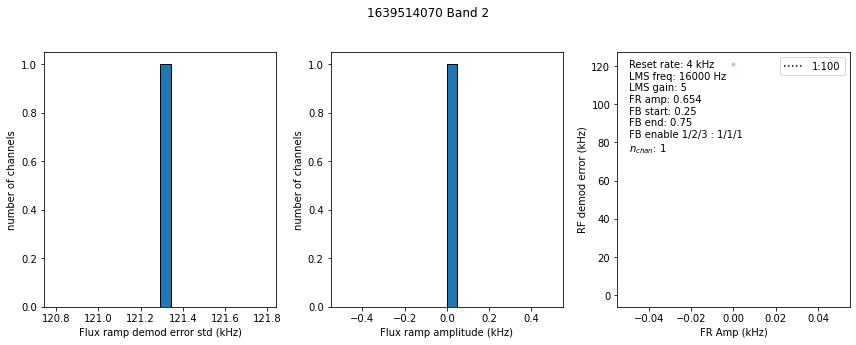

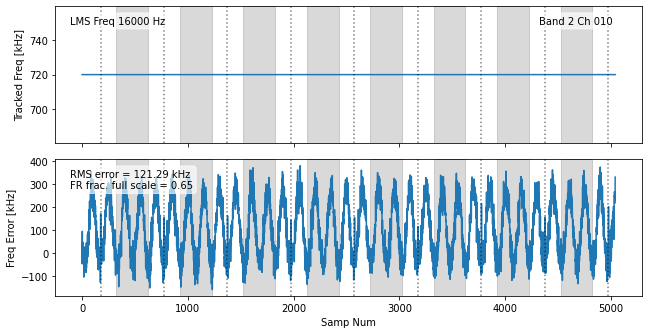

In [18]:
S.tracking_setup(band=2, channel=10, reset_rate_khz=4, n_phi0=4, lms_freq_hz=None, meas_flux_ramp_amp=True, make_plot=True, lms_gain=5, feedback_start_frac=0.25, feedback_end_frac=1-0.25, lms_enable1=1, lms_enable2=1, lms_enable3=1) 

Our error signal is cleaned up and we are now tracking 3 harmonics of the phi0 response.

### Examine DAC output
We can again look at the DAC output but this time we will be playing tones and doing flux ramp tracking:


[ 2021-12-14 20:35:15 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2021-12-14 20:35:15 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:35:15 ]  DAC plot saved to /data/smurf_data/20211214/1639512888/plots/1639514115_dac2.png
[ 2021-12-14 20:35:15 ]  Saving raw dac data to /data/smurf_data/20211214/1639512888/outputs/1639514115_dac2


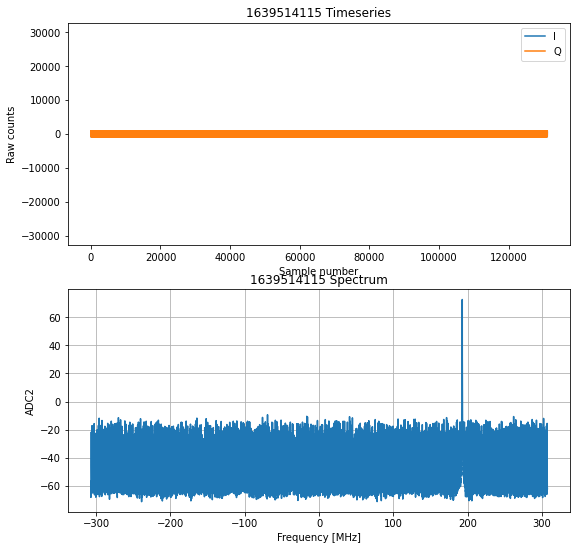

In [20]:
dac_data = S.read_dac_data(data_length=2**16, band=2, make_plot=True, show_plot=True)

[ 2021-12-14 20:35:57 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2021-12-14 20:35:57 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-12-14 20:35:57 ]  ADC plot saved to /data/smurf_data/20211214/1639512888/plots/1639514157_adc2.png
[ 2021-12-14 20:35:57 ]  Saving raw adc data to /data/smurf_data/20211214/1639512888/outputs/1639514157_adc2


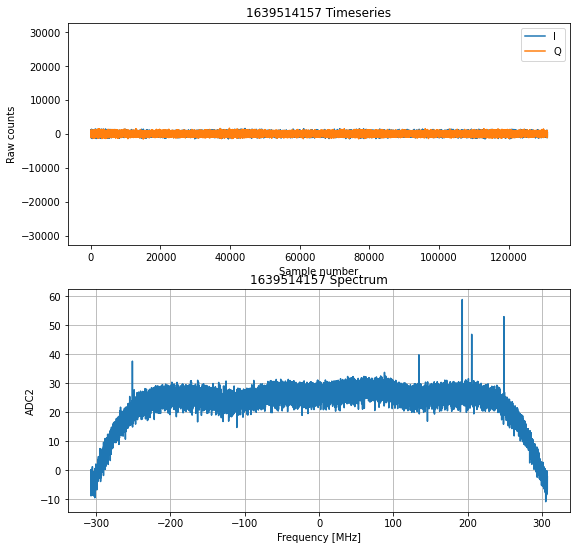

In [22]:
adc_data = S.read_adc_data(data_length=2**16, band=2, make_plot=True, show_plot=True)

Our resonator at 0MHz had the largest depth and we can see the power at the ADC is lowest.